In [17]:
import pandas as pd
import ace_tools_open as tools

# Load the dataset
file_path = 'data/gld_price_data.csv'  # Thay đường dẫn thực tế
gold_price_data = pd.read_csv(file_path)

# Convert the Date column to datetime format
gold_price_data['Date'] = pd.to_datetime(gold_price_data['Date'])

# Generate info-like output using pandas
info_dict = {
    "Column": gold_price_data.columns,
    "Non-Null Count": gold_price_data.notnull().sum().values,
    "Dtype": gold_price_data.dtypes.values
}

info_dataframe = pd.DataFrame(info_dict)

# Display the info DataFrame directly
print("Gold Price Data Info (Custom):\n")
print(info_dataframe)

# Generate and display descriptive statistics using ace_tools_open
description = gold_price_data.describe()
tools.display_dataframe_to_user(name="Gold Price Data Overview", dataframe=description)


Gold Price Data Info (Custom):

    Column  Non-Null Count           Dtype
0     Date            2290  datetime64[ns]
1      SPX            2290         float64
2      GLD            2290         float64
3      USO            2290         float64
4      SLV            2290         float64
5  EUR/USD            2290         float64
Gold Price Data Overview


In [18]:
import pandas as pd
import os

# Load the dataset
file_path = 'data/gld_price_data.csv'  # Replace with your actual file path
gold_price_data = pd.read_csv(file_path)

# Convert the Date column to datetime format
gold_price_data['Date'] = pd.to_datetime(gold_price_data['Date'])

# Extract time-based features
gold_price_data['Year'] = gold_price_data['Date'].dt.year
gold_price_data['Month'] = gold_price_data['Date'].dt.month
gold_price_data['Day'] = gold_price_data['Date'].dt.day
gold_price_data['DayOfWeek'] = gold_price_data['Date'].dt.dayofweek
gold_price_data['IsWeekend'] = gold_price_data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Preprocessing steps
# 1. Drop duplicate rows
gold_price_data_cleaned = gold_price_data.drop_duplicates()

# 2. Sort data by Date
gold_price_data_cleaned = gold_price_data_cleaned.sort_values(by='Date')

# Ensure the output directory exists
output_dir = 'data'
os.makedirs(output_dir, exist_ok=True)

# Save the cleaned dataset
cleaned_file_path = os.path.join(output_dir, 'gld_price_data_cleaned.csv')
gold_price_data_cleaned.to_csv(cleaned_file_path, index=False)

# Print confirmation
print(f"Data has been cleaned and saved to: {cleaned_file_path}")


Data has been cleaned and saved to: data\gld_price_data_cleaned.csv


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load the cleaned dataset
file_path = 'data/gld_price_data_cleaned.csv'  # Replace with the actual path
gold_price_data = pd.read_csv(file_path)

# Feature engineering: Separate features and target
X = gold_price_data.drop(columns=['GLD', 'Date'])  # Include time-based features
y = gold_price_data['GLD']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define models and hyperparameters for GridSearchCV
models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10]
        }
    }
}

# Train and evaluate models using GridSearchCV
results = {}
for model_name, config in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        cv=kf,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    
    # Best model and its performance
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[model_name] = {
        "Best Parameters": grid_search.best_params_,
        "MSE": mse,
        "R2 Score": r2
    }
    
    print(f"{model_name} completed. Best Parameters: {grid_search.best_params_}, MSE: {mse}, R2 Score: {r2}")

# Display the results
for model_name, result in results.items():
    print(f"\nModel: {model_name}")
    for key, value in result.items():
        print(f"{key}: {value}")


Training Linear Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Linear Regression completed. Best Parameters: {}, MSE: 45.33240871721412, R2 Score: 0.9173218724359355
Training Random Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Random Forest completed. Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}, MSE: 2.237983991789385, R2 Score: 0.995918321324734

Model: Linear Regression
Best Parameters: {}
MSE: 45.33240871721412
R2 Score: 0.9173218724359355

Model: Random Forest
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
MSE: 2.237983991789385
R2 Score: 0.995918321324734


In [20]:
import os
import joblib
import pandas as pd

# Directory to save models and results
output_dir = "models_and_results"
os.makedirs(output_dir, exist_ok=True)

# Save models and results
results_list = []
for model_name, config in models.items():
    # Train the model with best parameters
    best_model = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        cv=kf,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=1
    )
    best_model.fit(X_train, y_train)  # Train the model
    
    # Save the trained model
    model_file_path = os.path.join(output_dir, f"{model_name.replace(' ', '_').lower()}_model.joblib")
    joblib.dump(best_model.best_estimator_, model_file_path)
    
    # Collect results for CSV
    y_pred = best_model.best_estimator_.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    result_row = {
        "Model": model_name,
        "Best Parameters": str(best_model.best_params_),
        "MSE": mse,
        "R2 Score": r2
    }
    results_list.append(result_row)
    
    print(f"Saved {model_name} model to {model_file_path}")

# Save results to a CSV file
results_df = pd.DataFrame(results_list)
results_csv_path = os.path.join(output_dir, "model_evaluation_results.csv")
results_df.to_csv(results_csv_path, index=False)

print(f"Saved evaluation results to {results_csv_path}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Saved Linear Regression model to models_and_results\linear_regression_model.joblib
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Saved Random Forest model to models_and_results\random_forest_model.joblib
Saved evaluation results to models_and_results\model_evaluation_results.csv


In [21]:
import pandas as pd
import joblib
import os

# Define the path to the directory containing the saved models
models_dir = "models_and_results"

# Load the sample input (replace with actual sample data, including time features)
sample_input = {
    "SPX": [1500],       # Example input for SPX
    "USO": [70],         # Example input for USO
    "SLV": [15],         # Example input for SLV
    "EUR/USD": [1.2],    # Example input for EUR/USD
    "Year": [2024],      # Example year
    "Month": [11],       # Example month
    "Day": [25],         # Example day
    "DayOfWeek": [0],    # Example: Monday (0 = Monday, 6 = Sunday)
    "IsWeekend": [0]     # Example: Not weekend
}
sample_df = pd.DataFrame(sample_input)

# List all model files
model_files = [f for f in os.listdir(models_dir) if f.endswith('.joblib')]

# Iterate through saved models and make predictions
print("Predictions on sample input:")
for model_file in model_files:
    model_path = os.path.join(models_dir, model_file)
    model_name = model_file.split('_model.joblib')[0].replace('_', ' ').title()
    
    # Load the model
    model = joblib.load(model_path)
    
    # Make a prediction
    prediction = model.predict(sample_df)
    print(f"{model_name} Prediction: {prediction[0]:.2f}")


Predictions on sample input:
Linear Regression Prediction: 228.01
Random Forest Prediction: 113.40


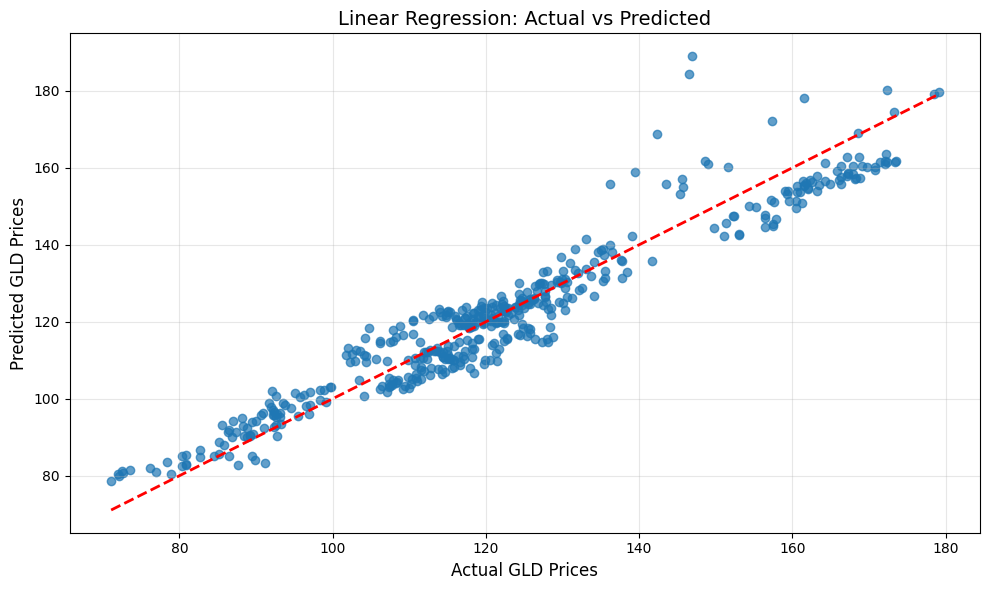

Saved Actual vs Predicted plot for Linear Regression to visualizations\linear_regression_actual_vs_predicted.png


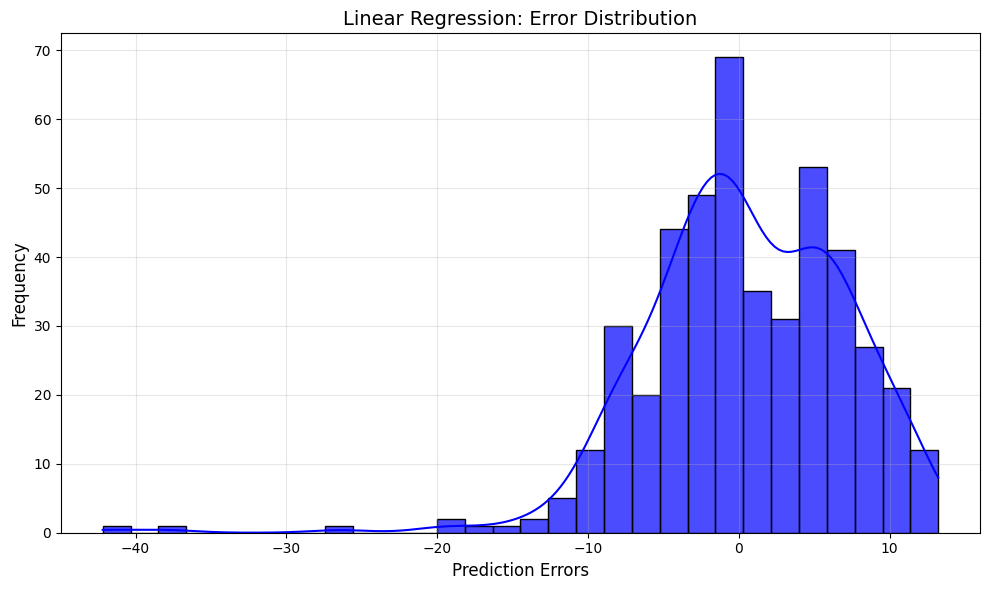

Saved Error Distribution plot for Linear Regression to visualizations\linear_regression_error_distribution.png


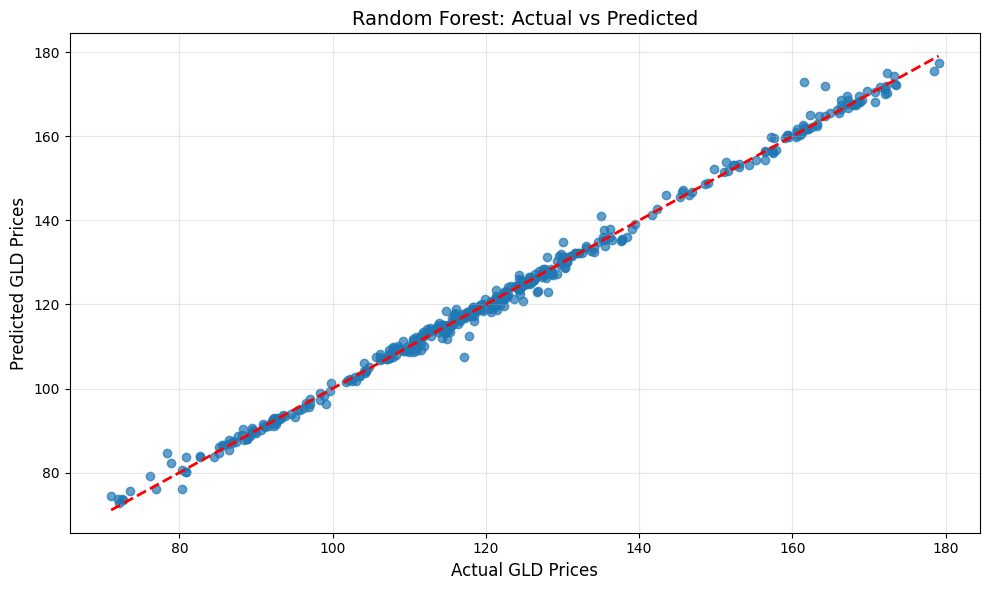

Saved Actual vs Predicted plot for Random Forest to visualizations\random_forest_actual_vs_predicted.png


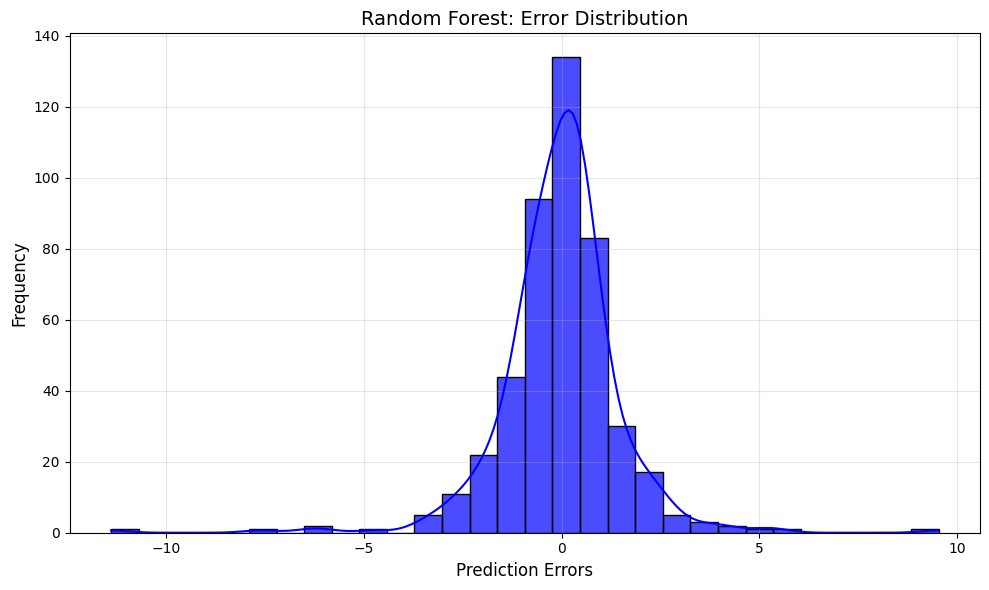

Saved Error Distribution plot for Random Forest to visualizations\random_forest_error_distribution.png


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create directories for saving visualizations
visualization_dir = "visualizations"
os.makedirs(visualization_dir, exist_ok=True)

for model_name, config in models.items():
    # Load the best model from results
    best_model = config["model"]
    best_model.fit(X_train, y_train)  # Ensure it's trained (if not already)
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Visualization 1: Actual vs Predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
    plt.title(f"{model_name}: Actual vs Predicted", fontsize=14)
    plt.xlabel("Actual GLD Prices", fontsize=12)
    plt.ylabel("Predicted GLD Prices", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    file_path_actual_vs_pred = os.path.join(visualization_dir, f"{model_name.replace(' ', '_').lower()}_actual_vs_predicted.png")
    plt.savefig(file_path_actual_vs_pred)
    plt.show()
    print(f"Saved Actual vs Predicted plot for {model_name} to {file_path_actual_vs_pred}")
    
    # Visualization 2: Error Distribution
    errors = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=30, kde=True, color='blue', alpha=0.7)
    plt.title(f"{model_name}: Error Distribution", fontsize=14)
    plt.xlabel("Prediction Errors", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    file_path_error_dist = os.path.join(visualization_dir, f"{model_name.replace(' ', '_').lower()}_error_distribution.png")
    plt.savefig(file_path_error_dist)
    plt.show()
    print(f"Saved Error Distribution plot for {model_name} to {file_path_error_dist}")
